10-Feb-26 11:33:05: Loading files for group: probe: 1, drate: brst, level: l2, datatype: des-dist, after sorting and filtering:
10-Feb-26 11:33:05: pydata\mms1\fpi\brst\l2\des-dist\2017\01\28\mms1_fpi_brst_l2_des-dist_20170128090703_v3.4.0.cdf
10-Feb-26 11:33:19: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dis-dist, after sorting and filtering:
10-Feb-26 11:33:19: pydata\mms1\fpi\brst\l2\dis-dist\2017\01\28\mms1_fpi_brst_l2_dis-dist_20170128090703_v3.4.0.cdf
10-Feb-26 11:33:22: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dis-moms, after sorting and filtering:
10-Feb-26 11:33:22: pydata\mms1\fpi\brst\l2\dis-moms\2017\01\28\mms1_fpi_brst_l2_dis-moms_20170128090703_v3.4.0.cdf
10-Feb-26 11:33:23: Loading files for group: probe: 1, drate: brst, level: l2, datatype: des-moms, after sorting and filtering:
10-Feb-26 11:33:23: pydata\mms1\fpi\brst\l2\des-moms\2017\01\28\mms1_fpi_brst_l2_des-moms_20170128090703_v3.4.0.cdf
10-Feb-26 11:33:24: Load


=== Data Resolution Report ===
          t_ne | N=    75 | dt_med=   30.000 ms | dt_mean=   30.000 ms | dt_min=   30.000 ms | dt_max=   30.009 ms | fs_med=    33.33 Hz
          t_ni | N=    15 | dt_med=  150.000 ms | dt_mean=  150.001 ms | dt_min=  150.000 ms | dt_max=  150.009 ms | fs_med=     6.67 Hz
          t_ve | N=    75 | dt_med=   30.000 ms | dt_mean=   30.000 ms | dt_min=   30.000 ms | dt_max=   30.009 ms | fs_med=    33.33 Hz
          t_vi | N=    15 | dt_med=  150.000 ms | dt_mean=  150.001 ms | dt_min=  150.000 ms | dt_max=  150.009 ms | fs_med=     6.67 Hz
           t_B | N=   288 | dt_med=    7.812 ms | dt_mean=    7.813 ms | dt_min=    7.812 ms | dt_max=    7.813 ms | fs_med=   128.00 Hz
           t_E | N= 18457 | dt_med=    0.122 ms | dt_mean=    0.122 ms | dt_min=    0.122 ms | dt_max=    0.122 ms | fs_med=  8192.00 Hz
     t_ref_out | N=    75 | dt_med=   30.000 ms | dt_mean=   30.000 ms | dt_min=   30.000 ms | dt_max=   30.009 ms | fs_med=    33.33 Hz
       t_

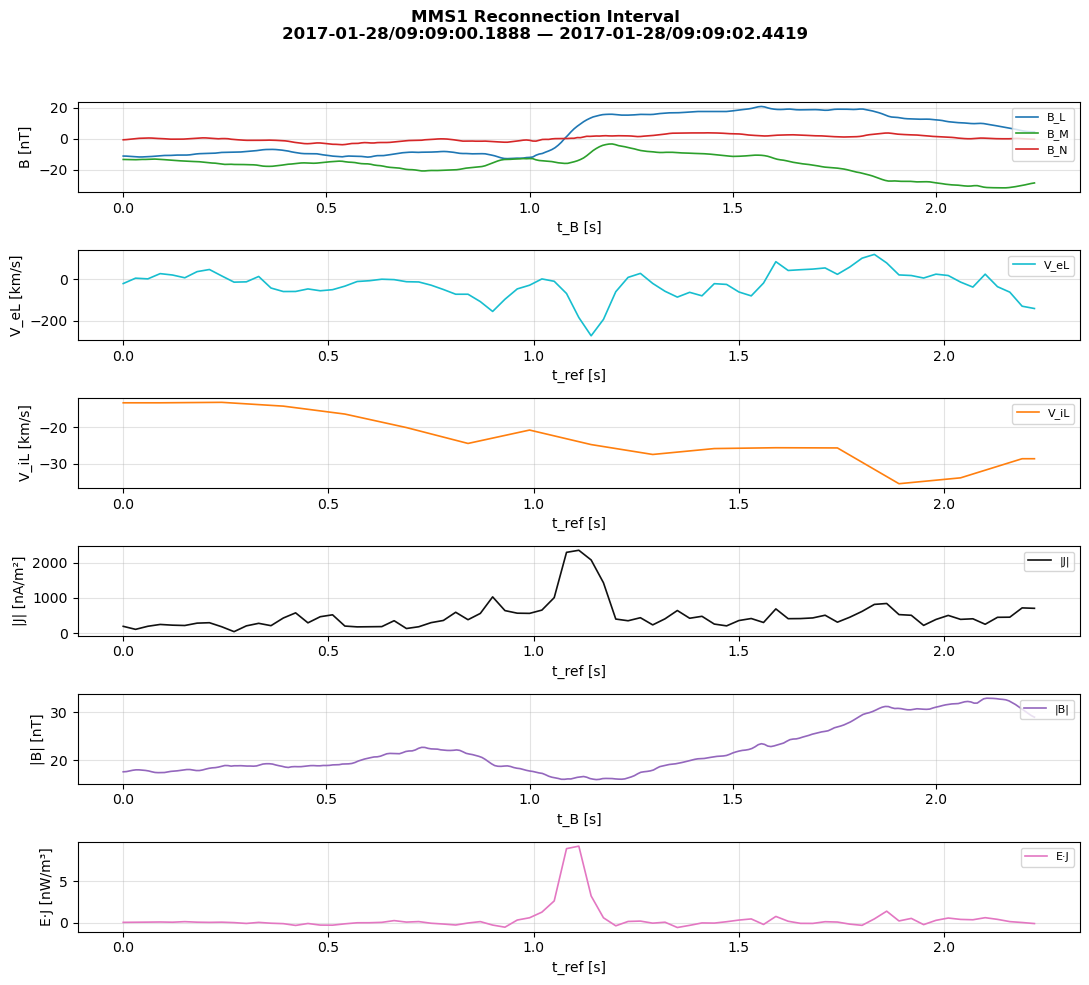

In [3]:
# ================================================================
# Clean MMS LMN extraction + stack plot from ONLY a given time range
# with custom colors + cadence/resolution report
# Author:  Deep P. Ghuge (NASA GSFC/CUA)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pyspedas.projects.mms import fpi, fgm, edp
from pytplot import get_data


# ----------------------------
# Small helpers
# ----------------------------
def _require_tplot(var_name):
    out = get_data(var_name)
    if out is None:
        raise RuntimeError(f"Missing tplot variable: {var_name}")
    return out


def _clean_tv(t, v):
    t = np.asarray(t, dtype=float)
    v = np.asarray(v, dtype=float)

    if v.ndim == 1:
        mask = np.isfinite(t) & np.isfinite(v)
    else:
        mask = np.isfinite(t) & np.all(np.isfinite(v), axis=1)

    t = t[mask]
    v = v[mask]

    if t.size < 2:
        raise ValueError("Not enough finite points after cleaning.")

    # sort + unique timestamps
    order = np.argsort(t)
    t = t[order]
    v = v[order]
    t_unique, idx = np.unique(t, return_index=True)
    v = v[idx]
    t = t_unique

    if t.size < 2:
        raise ValueError("Not enough unique points after cleaning.")
    return t, v


def _interp_to(t_src, y_src, t_dst, kind="linear", policy="edge_hold"):
    """
    policy:
      - 'strict'        : no extrapolation, outside -> NaN
      - 'edge_hold'     : outside -> first/last value
      - 'linear_extrap' : full linear extrapolation
    """
    t_src, y_src = _clean_tv(t_src, y_src)
    t_dst = np.asarray(t_dst, dtype=float)

    if policy == "strict":
        fill = np.nan
    elif policy == "edge_hold":
        if y_src.ndim == 1:
            fill = (float(y_src[0]), float(y_src[-1]))
        else:
            fill = (y_src[0], y_src[-1])
    elif policy == "linear_extrap":
        fill = "extrapolate"
    else:
        raise ValueError("policy must be one of: strict, edge_hold, linear_extrap")

    f = interp1d(
        t_src,
        y_src,
        axis=0,
        kind=kind,
        bounds_error=False,
        fill_value=fill,
        assume_sorted=True,
    )
    return f(t_dst)


def _unit(v, eps=1e-14):
    n = np.linalg.norm(v)
    if n < eps:
        raise ValueError("Vector norm too small.")
    return v / n


def _mva_matrix(B):
    B = np.asarray(B, dtype=float)
    cov = np.cov(B - np.mean(B, axis=0), rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    L, M, N = eigvecs[:, order].T
    if np.dot(np.cross(L, M), N) < 0:
        N = -N
    return np.column_stack((L, M, N))


def _hmva_matrix(B):
    """
    Hybrid MVA:
      N ~ b_start x b_end
      L from max variance direction
      M = L x N
    """
    B = np.asarray(B, dtype=float)
    n = len(B)
    k = max(5, int(0.1 * n))

    b_start = np.nanmedian(B[:k], axis=0)
    b_end = np.nanmedian(B[-k:], axis=0)

    cross_be = np.cross(b_start, b_end)
    if np.linalg.norm(cross_be) < 1e-12:
        return _mva_matrix(B)

    N = _unit(cross_be)

    cov = np.cov(B - np.mean(B, axis=0), rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    L_mva = eigvecs[:, np.argmax(eigvals)]

    M = _unit(np.cross(L_mva, N))
    L = _unit(np.cross(M, N))

    return np.column_stack((L, M, N))


def _resolution_stats(t):
    """
    Returns cadence stats in seconds + Hz based on diff(t).
    """
    t = np.asarray(t, dtype=float)
    if t.size < 2:
        return {
            "n": int(t.size),
            "dt_med_s": np.nan,
            "dt_mean_s": np.nan,
            "dt_min_s": np.nan,
            "dt_max_s": np.nan,
            "fs_med_hz": np.nan,
        }

    dt = np.diff(np.sort(np.unique(t)))
    dt = dt[np.isfinite(dt) & (dt > 0)]

    if dt.size == 0:
        return {
            "n": int(t.size),
            "dt_med_s": np.nan,
            "dt_mean_s": np.nan,
            "dt_min_s": np.nan,
            "dt_max_s": np.nan,
            "fs_med_hz": np.nan,
        }

    dt_med = float(np.median(dt))
    return {
        "n": int(t.size),
        "dt_med_s": dt_med,
        "dt_mean_s": float(np.mean(dt)),
        "dt_min_s": float(np.min(dt)),
        "dt_max_s": float(np.max(dt)),
        "fs_med_hz": float(1.0 / dt_med) if dt_med > 0 else np.nan,
    }


def _print_resolution_report(resolutions):
    print("\n=== Data Resolution Report ===")
    for name, r in resolutions.items():
        print(
            f"{name:>14s} | N={r['n']:6d} | "
            f"dt_med={r['dt_med_s']*1e3:9.3f} ms | "
            f"dt_mean={r['dt_mean_s']*1e3:9.3f} ms | "
            f"dt_min={r['dt_min_s']*1e3:9.3f} ms | "
            f"dt_max={r['dt_max_s']*1e3:9.3f} ms | "
            f"fs_med={r['fs_med_hz']:9.2f} Hz"
        )
    print("==============================\n")


def _write_resolution_report(resolutions, out_path="resolution_report.txt"):
    lines = []
    lines.append("=== Data Resolution Report ===\n")
    for name, r in resolutions.items():
        lines.append(
            f"{name:>14s} | N={r['n']:6d} | "
            f"dt_med={r['dt_med_s']*1e3:9.3f} ms | "
            f"dt_mean={r['dt_mean_s']*1e3:9.3f} ms | "
            f"dt_min={r['dt_min_s']*1e3:9.3f} ms | "
            f"dt_max={r['dt_max_s']*1e3:9.3f} ms | "
            f"fs_med={r['fs_med_hz']:9.2f} Hz\n"
        )
    lines.append("==============================\n")

    with open(out_path, "w", encoding="utf-8") as f:
        f.writelines(lines)

    print(f"✅ Saved: {out_path}")


# ----------------------------
# Core extraction
# ----------------------------
def extract_lmn_for_trange(
    trange,
    probe=1,
    data_rate="brst",
    interp_policy="edge_hold",
    drop_nan_rows=True,
    print_resolutions=True
):
    p = str(probe)
    s = f"_{data_rate}"

    # 1) Load MMS data for given range
    fpi(data_rate=data_rate, trange=trange, center_measurement=True, probe=p, time_clip=True)
    fgm(trange=trange, time_clip=True, data_rate=data_rate, probe=p)
    edp(trange=trange, time_clip=True, data_rate=data_rate, probe=p)

    # 2) Pull required variables
    t_ne, ne = _require_tplot(f"mms{p}_des_numberdensity{s}")
    t_ni, ni = _require_tplot(f"mms{p}_dis_numberdensity{s}")
    t_ve, ve = _require_tplot(f"mms{p}_des_bulkv_gse{s}")
    t_vi, vi = _require_tplot(f"mms{p}_dis_bulkv_gse{s}")

    t_B, B = _require_tplot(f"mms{p}_fgm_b_gse_{data_rate}_l2_bvec")
    t_E, E = _require_tplot(f"mms{p}_edp_dce_gse_{data_rate}_l2")

    # clean
    t_ne, ne = _clean_tv(t_ne, ne)
    t_ni, ni = _clean_tv(t_ni, ni)
    t_ve, ve = _clean_tv(t_ve, ve)
    t_vi, vi = _clean_tv(t_vi, vi)
    t_B, B = _clean_tv(t_B, B)
    t_E, E = _clean_tv(t_E, E)

    # raw resolution stats
    resolutions = {
        "t_ne": _resolution_stats(t_ne),
        "t_ni": _resolution_stats(t_ni),
        "t_ve": _resolution_stats(t_ve),
        "t_vi": _resolution_stats(t_vi),
        "t_B": _resolution_stats(t_B),
        "t_E": _resolution_stats(t_E),
    }

    # Reference timeline = electron velocity clock
    t_ref = t_ve.copy()

    # 3) Interpolate to reference timeline
    ne_ref = _interp_to(t_ne, ne, t_ref, kind="linear", policy=interp_policy)
    ni_ref = _interp_to(t_ni, ni, t_ref, kind="linear", policy=interp_policy)
    vi_ref = _interp_to(t_vi, vi, t_ref, kind="linear", policy=interp_policy)

    B_ref = _interp_to(t_B, B, t_ref, kind="linear", policy=interp_policy)
    E_ref = _interp_to(t_E, E, t_ref, kind="linear", policy=interp_policy)

    # 4) LMN transform from B (native B timeline)
    R = _hmva_matrix(B)
    B_lmn = B @ R

    # Rotate vectors on reference timeline
    Ve_lmn = ve @ R
    Vi_lmn = vi_ref @ R

    # 5) Current density from FPI moments: J = e (ni*Vi - ne*Ve)
    e_charge = 1.602e-19
    ne_m3 = ne_ref * 1e6
    ni_m3 = ni_ref * 1e6
    ve_ms = ve * 1e3
    vi_ms = vi_ref * 1e3

    J = e_charge * (ni_m3[:, None] * vi_ms - ne_m3[:, None] * ve_ms)
    J_mag = np.linalg.norm(J, axis=1)
    J_lmn = J @ R

    # 6) E·J in electron frame correction
    E_vpm = E_ref * 1e-3
    B_tesla = B_ref * 1e-9
    E_corr = E_vpm + np.cross(ve_ms, B_tesla)
    EJ_nWm3 = np.einsum("ij,ij->i", J, E_corr) * 1e9

    # Optional cleanup for ML input stability
    if drop_nan_rows:
        valid = (
            np.isfinite(ne_ref)
            & np.isfinite(ni_ref)
            & np.all(np.isfinite(vi_ref), axis=1)
            & np.all(np.isfinite(ve), axis=1)
            & np.all(np.isfinite(J_lmn), axis=1)
            & np.isfinite(J_mag)
            & np.isfinite(EJ_nWm3)
        )
        t_ref = t_ref[valid]
        Ve_lmn = Ve_lmn[valid]
        Vi_lmn = Vi_lmn[valid]
        J_lmn = J_lmn[valid]
        J_mag = J_mag[valid]
        EJ_nWm3 = EJ_nWm3[valid]

    # Add final output timeline resolutions
    resolutions["t_ref_out"] = _resolution_stats(t_ref)
    resolutions["t_B_out"] = _resolution_stats(t_B)

    if print_resolutions:
        _print_resolution_report(resolutions)

    # independent time axes
    time_B = t_B - t_B[0]
    time_ref = t_ref - t_ref[0]

    rs = {
        "time_B": time_B,
        "time_ref": time_ref,

        "BL": B_lmn[:, 0],
        "BM": B_lmn[:, 1],
        "BN": B_lmn[:, 2],

        "VeL": Ve_lmn[:, 0],
        "VeM": Ve_lmn[:, 1],
        "VeN": Ve_lmn[:, 2],

        "ViL": Vi_lmn[:, 0],
        "ViM": Vi_lmn[:, 1],
        "ViN": Vi_lmn[:, 2],

        "JL": J_lmn[:, 0],
        "JM": J_lmn[:, 1],
        "JN": J_lmn[:, 2],
        "J_mag": J_mag,

        "E_dot_J": EJ_nWm3,
    }

    return rs, resolutions


# ----------------------------
# Plotting
# ----------------------------
def plot_stack(rs, trange, probe=1, colors=None):
    """
    colors keys:
      BL,BM,BN,VeL,ViL,Jmag,Bt,EJ
    """
    if colors is None:
        colors = {
            "BL": "#1f77b4",   # blue
            "BM": "#2ca02c",   # green
            "BN": "#d62728",   # red
            "VeL": "#17becf",  # cyan
            "ViL": "#ff7f0e",  # orange
            "Jmag": "#111111", # near-black
            "Bt": "#9467bd",   # purple
            "EJ": "#e377c2",   # magenta-pink
        }

    tB = rs["time_B"]
    tr = rs["time_ref"]

    BL, BM, BN = rs["BL"], rs["BM"], rs["BN"]
    VeL, ViL = rs["VeL"], rs["ViL"]
    Jmag = rs["J_mag"]
    EJ = rs["E_dot_J"]
    Bt = np.sqrt(BL**2 + BM**2 + BN**2)

    fig, axes = plt.subplots(6, 1, figsize=(11, 10), sharex=False)
    fig.suptitle(
        f"MMS{probe} Reconnection Interval\n{trange[0]} — {trange[1]}",
        fontsize=12, fontweight="bold"
    )

    # B components (native B timeline)
    axes[0].plot(tB, BL, lw=1.2, color=colors["BL"], label="B_L")
    axes[0].plot(tB, BM, lw=1.2, color=colors["BM"], label="B_M")
    axes[0].plot(tB, BN, lw=1.2, color=colors["BN"], label="B_N")
    axes[0].set_ylabel("B [nT]")
    axes[0].legend(loc="upper right", fontsize=8)
    axes[0].grid(True, alpha=0.35)
    axes[0].set_xlabel("t_B [s]")

    # Electron velocity
    axes[1].plot(tr, VeL, lw=1.2, color=colors["VeL"], label="V_eL")
    axes[1].set_ylabel("V_eL [km/s]")
    axes[1].legend(loc="upper right", fontsize=8)
    axes[1].grid(True, alpha=0.35)
    axes[1].set_xlabel("t_ref [s]")

    # Ion velocity
    axes[2].plot(tr, ViL, lw=1.2, color=colors["ViL"], label="V_iL")
    axes[2].set_ylabel("V_iL [km/s]")
    axes[2].legend(loc="upper right", fontsize=8)
    axes[2].grid(True, alpha=0.35)
    axes[2].set_xlabel("t_ref [s]")

    # Current magnitude
    axes[3].plot(tr, Jmag * 1e9, lw=1.2, color=colors["Jmag"], label="|J|")
    axes[3].set_ylabel("|J| [nA/m²]")
    axes[3].legend(loc="upper right", fontsize=8)
    axes[3].grid(True, alpha=0.35)
    axes[3].set_xlabel("t_ref [s]")

    # |B|
    axes[4].plot(tB, Bt, lw=1.2, color=colors["Bt"], label="|B|")
    axes[4].set_ylabel("|B| [nT]")
    axes[4].legend(loc="upper right", fontsize=8)
    axes[4].grid(True, alpha=0.35)
    axes[4].set_xlabel("t_B [s]")

    # E·J
    axes[5].plot(tr, EJ, lw=1.2, color=colors["EJ"], label="E·J")
    axes[5].set_ylabel("E·J [nW/m³]")
    axes[5].set_xlabel("t_ref [s]")
    axes[5].legend(loc="upper right", fontsize=8)
    axes[5].grid(True, alpha=0.35)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    TRANGE = ["2017-01-28/09:09:00.1888", "2017-01-28/09:09:02.4419"]
    PROBE = 1

    rs, res = extract_lmn_for_trange(
        trange=TRANGE,
        probe=PROBE,
        data_rate="brst",
        interp_policy="edge_hold",  # strict / edge_hold / linear_extrap
        drop_nan_rows=True,
        print_resolutions=True
    )

    np.savez("mms_lmn_outputs_clean.npz", **rs)
    print("✅ Saved: mms_lmn_outputs_clean.npz")

    _write_resolution_report(res, out_path="resolution_report.txt")

    plot_stack(rs, TRANGE, probe=PROBE)
